# Classification of complete and censored functional data   

## We follow the LDA method described in the paper *Achieving near perfect classification for functional data* by Aurore Delaigle and Peter Hall. In particular, we assume that the two populations share the same covariance kernel. We then restrict this method to the case where the data curves are only partially observed.  

###  Import necessary modules. All useful functions are in $\texttt{functions.py}$.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%load_ext 
%autoreload 2

UsageError: Missing module name.


### Defining the parameters of the data 

In [4]:
n = 1000
r = 3
N = 100
t = np.linspace(0,1,N)
sds = np.append(np.array([1.5,0.55,0.02]),0.001 * np.ones(r-3) + np.random.normal(0,0.0001,r-3)).reshape(r,1)
sds = np.sqrt(sds)

### Defining two different mean functions \begin{equation*} \mu_1(t) = 0, \ \ \mu_2(t) = \frac{\sin(t)}{10}  \end{equation*} for the two populations

In [5]:
def mu1(t):
    return np.zeros(t.shape)
def mu2(t):
    return 100 * np.cos(2*np.pi*t)

### Defining the basis functions, here truncated gaussian densities

In [6]:
def g(x,n):
    if n == 0:
        return scipy.stats.norm.pdf(x, loc = 0.5, scale = 0.6)
    elif n == 1:
        return scipy.stats.norm.pdf(x, loc = 0.2, scale = 0.25)
    elif n == 2:
        return scipy.stats.norm.pdf(x, loc = 0.8, scale = 0.2)
    else:
        print('Not defined')

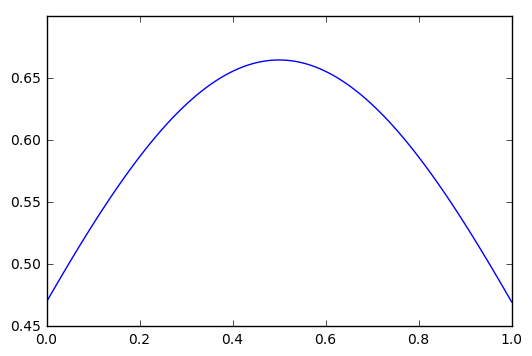

In [7]:
plt.plot(t,g(t,0))

def g(x,n):
    if n == -1:
        return np.array([1]* len(x))
    else:
        return np.sqrt(2)*np.sin(2*(n+1) * np.pi * x)

In [8]:
def X(t,rv):
    return np.sum(np.multiply(np.repeat(rv,N).reshape(r,N),np.array([g(t,i) for i in range(r)])),axis = 0)

### Note that the the two mean functions are quite close and so it seems hard to classify. The plot shows 10 samples having mean $\mu_1$ (in blue) and 10 samples having mean $\mu_2$ (in red) 

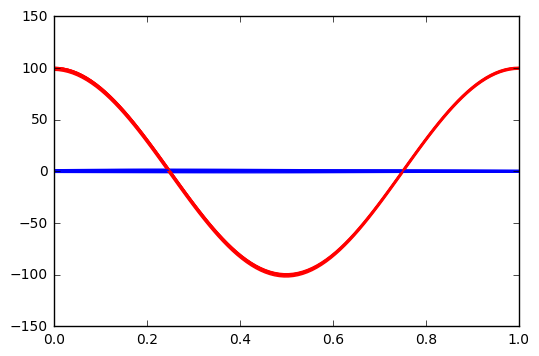

In [9]:
for i in range(10):
    plt.plot(t,generate_data(10, r, t, X, mu1, sds)[i],'b')
    plt.plot(t,generate_data(10, r, t, X, mu2, sds)[i],'r')

In [10]:
realK = get_real_cov(sds,N,g,t)

## Classification of complete functional data 

### Generating the data for the two populations. They share the same covariance kernel but have different mean functions.

In [11]:
data1 = generate_data(n, r, t, X, mu1, sds)
data2 = generate_data(n, r, t, X, mu2, sds)

### Estimated mean functions 

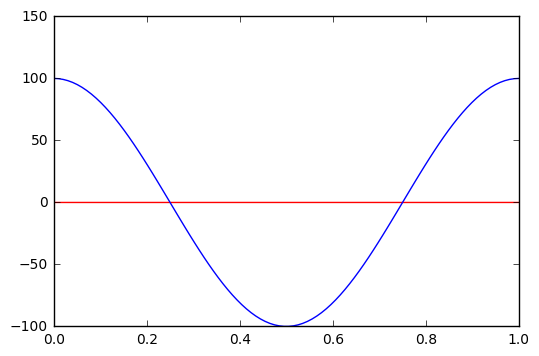

In [12]:
plt.plot(t,data1.mean(0),'r')
plt.plot(t,data2.mean(0),'b')

### Estimated smoothed covariance kernel. The estimation is quite satifying, with a relative error of 11% 

The relative error is 0.00609690278778


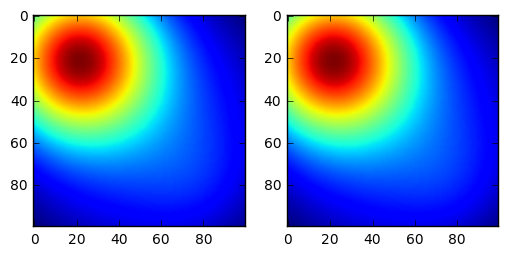

In [13]:
data_pool = np.r_[data1-data1.mean(0),data2-data2.mean(0)]
K = np.cov(data_pool, rowvar=False)
plt.subplot(1, 2, 1)
plt.imshow(K)

plt.subplot(1, 2, 2)
plt.imshow(realK)
score = np.linalg.norm(realK-K)/np.linalg.norm(realK)
print('The relative error is ' + str(score))

### Computing the function $\psi \in \mathbb{L}^2[0,1]$ such that the classifier \begin{equation*} T(X) = (\langle X,\psi \rangle - \langle \bar{X}_2,\psi \rangle)^2 - (\langle X,\psi \rangle - \langle \bar{X}_1,\psi \rangle)^2 \end{equation*} has the best theoretical performances

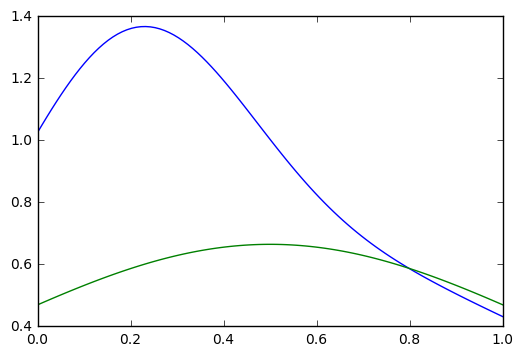

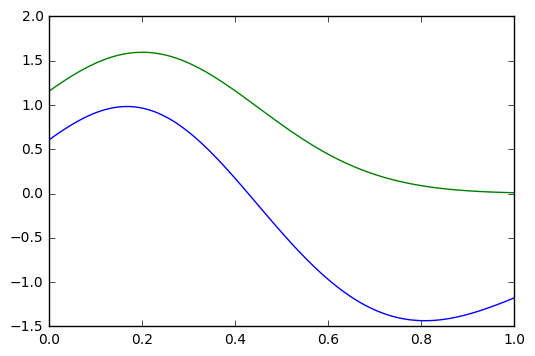

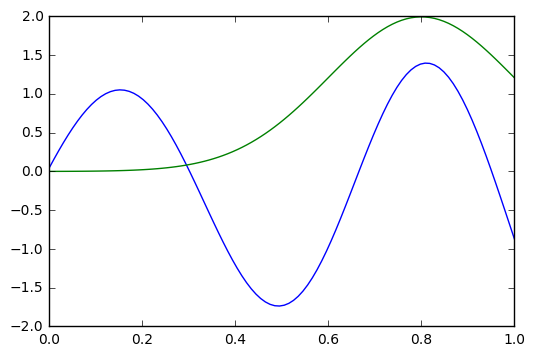

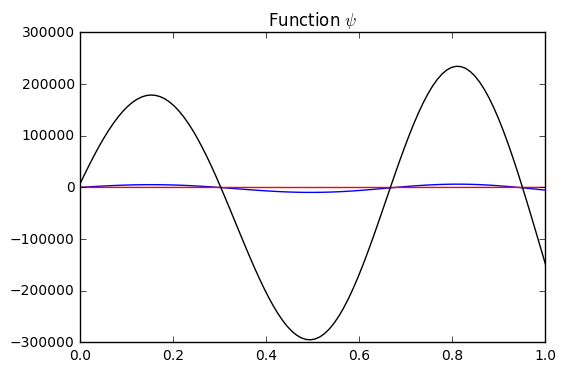

In [14]:
def get_psi(covaa):
    cov_svd = np.linalg.svd(covaa)
    est_eigv = cov_svd[1][:r]/N
    est_eigf = -cov_svd[0][:,:r]*10
    est_eigv = np.sqrt(est_eigv)
    for i in range(r):
        plt.plot(t,est_eigf[:,i])
        plt.plot(t,g(t,i))
        plt.show()
    mu_coef = (data2.mean(0)-data1.mean(0)) @ est_eigf
    plt.plot(t,est_eigf @ mu_coef,'b')
    plt.plot(t,data2.mean(0)-data1.mean(0),'r')
    psi = (mu_coef/est_eigv) @ est_eigf.T
    plt.plot(t,psi,'k')
    plt.title('Function $\psi$')
    return psi
psi = get_psi(realK)

from scipy.stats import norm
1- norm.cdf(0.5*np.sqrt(np.sum((mu_coef**2)/est_eigv))),0.5*np.sqrt(np.sum((mu_coef**2)/est_eigv))

### Defining the test $T(X)$ shown above 

In [15]:
psi @ (data1-data2).mean(0)

-876786361.86023903

In [16]:
def test(Y):
    ans = (Y @ psi - data1.mean(0) @ psi)**2 - (Y @ psi - data2.mean(0) @ psi)**2
    return ans/(N**2)

### Getting the results on the training set. We observe that the classification is very good in this case with an error rate of 13%, even though the mean functions $\mu_1$ and $\mu_2$ are quite close

In [17]:
train_results = np.zeros((1,2))
for i in range(n):
    qw,er = test(data1[i]), test(data2[i])
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

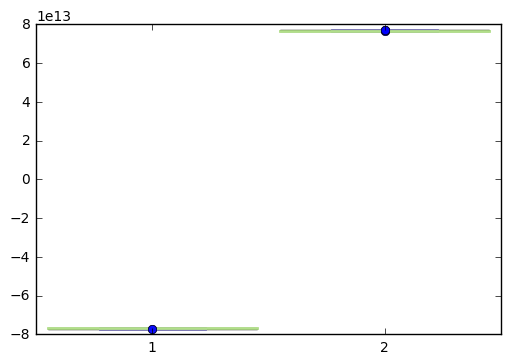

In [18]:
get_boxplots(train_results)

In [19]:
np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)

(0.0, 0.0)

In [20]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(np.r_[data1,data2], np.append(np.zeros(n),np.ones(n)))

/home/william/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [21]:
clf.score(np.r_[data1,data2],np.append(np.zeros(n),np.ones(n)))

1.0

### Generating test data and computing the classifier on those. We observe that the classification still has a satisfying error rate of 12.5% 

In [22]:
test_results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
    newX2 = generate_data(1,r,t,X,mu2,sds).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    test_results = np.r_[test_results,np.array([test(newX1), test(newX2)]).reshape((1,2))]
test_results = test_results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

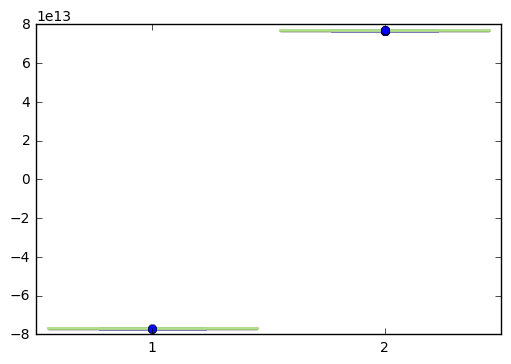

In [23]:
get_boxplots(test_results)

In [24]:
np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0)

(0.0, 0.0)

### Plots of the curves where the classifier $T(X)$ is the furthest from reality for both test population.

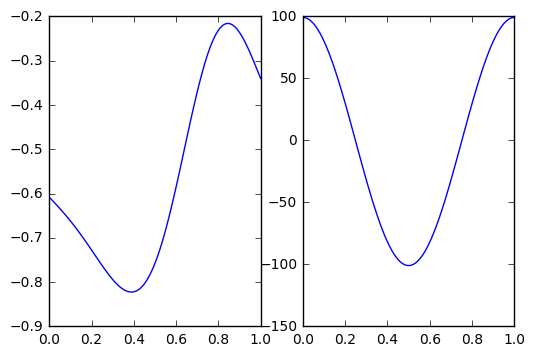

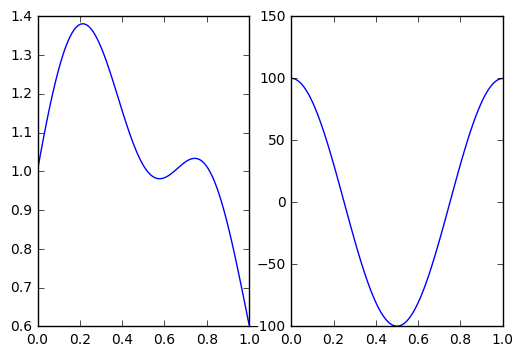

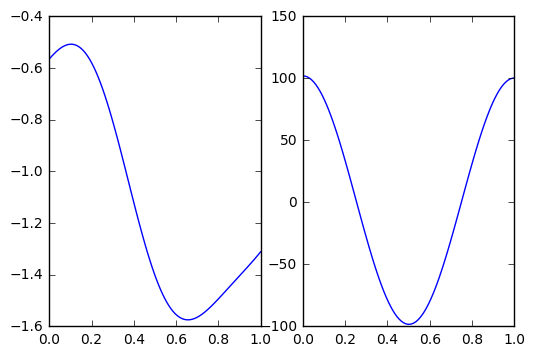

In [25]:
for i in range(3):
    a = np.argsort(test_results[:,0])[-(i+1)]
    b = np.argsort(test_results[:,1])[i]
    plt.subplot(1, 2, 1)
    plt.plot(t,newdata1[a])
    plt.subplot(1, 2, 2)
    plt.plot(t,newdata2[b])
    plt.show()

## Classification of complete functional data  

### Defining the bounds for the fragments. We use the same training data as above. 

In [26]:
#data1, data2 = data2, data1

In [27]:
delta = 0.9
bounds1, bounds21 = get_eff_bounds(delta=delta, N=N, n=n)
bounds2, bounds22 = get_eff_bounds(delta=delta, N=N, n=n)

In [28]:
frag1 = np.zeros((n,N))
frag2 = np.zeros((n,N))
for i in range(n):
    start, end = bounds1[i]
    frag1[i,start:end] = data1[i,start:end]
    frag1[i,:start] = np.nan
    frag1[i,end:] = np.nan
    start, end = bounds2[i]
    frag2[i,start:end] = data1[i,start:end]
    frag2[i,:start] = np.nan
    frag2[i,end:] = np.nan

In [29]:
np.nanmean(frag1,0)[89:91],data1.mean(0)[89:91]

(array([-0.01074719, -0.04360523]), array([-0.01074719, -0.01044284]))

In [30]:
np.mean(data1[bounds1[:,1]!=90,90])

-0.043605231039989763

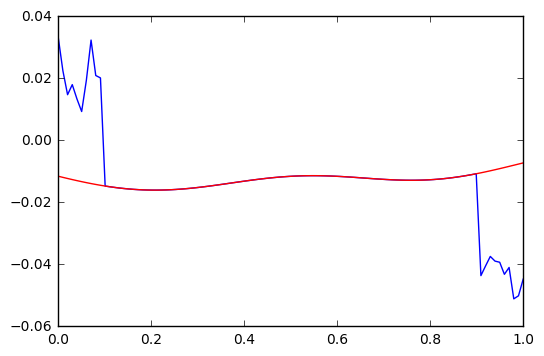

In [31]:
plt.plot(t,np.nanmean(frag1,0),'b')
plt.plot(t,data1.mean(0),'r')

In [32]:
print('Effective delta is ' + str(np.mean(bounds1[:,1]-bounds1[:,0])/(2*N) + np.mean(bounds2[:,1]-bounds2[:,0])/(2*N)))

Effective delta is 0.9


### Estimated mean functions from the fragments 

In [33]:
frag1 = np.zeros((n,N))
frag2 = np.zeros((n,N))
for i in range(n):
    start, end = bounds1[i]
    frag1[i,start:end] = data1[i,start:end]
    frag1[i,:start] = np.nan
    frag1[i,end:] = np.nan
    start, end = bounds2[i]
    frag2[i,start:end] = data1[i,start:end]
    frag2[i,:start] = np.nan
    frag2[i,end:] = np.nan

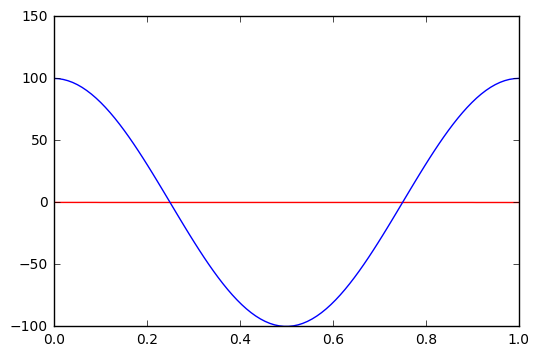

In [34]:
estmu1 = np.array([hmu(data1,i,bounds1) for i in range(N)])
estmu2 = np.array([hmu(data2,i,bounds2) for i in range(N)])
plt.plot(t,estmu1,'r')
plt.plot(t,estmu2,'b')

### Estimating the covariance kernel using the matrix completion method.  

In [35]:
trunc_cov = get_trunc_cov(np.r_[data1,data2],np.r_[bounds21,bounds22])
P = get_P(N,delta)
tmp = dog(r,P,trunc_cov)[1].reshape((N,-1))
est = tmp @ tmp.T

The relative error w.r.t. the smoothed estimated is 1277.41480345


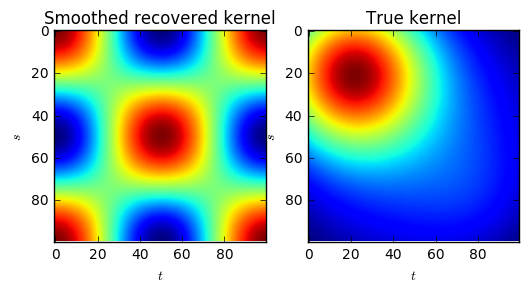

In [36]:
smooth_est = smooth_matrix(est,t)
plt.subplot(1, 2, 1)
plt.imshow(smooth_est)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('Smoothed recovered kernel')

plt.subplot(1, 2, 2)
plt.imshow(realK)
plt.xlabel('$t$')
plt.ylabel('$s$')
plt.title('True kernel')

score = np.linalg.norm(realK-smooth_est)/np.linalg.norm(realK)
print('The relative error w.r.t. the smoothed estimated is ' + str(score))

### Computing the function $\psi$

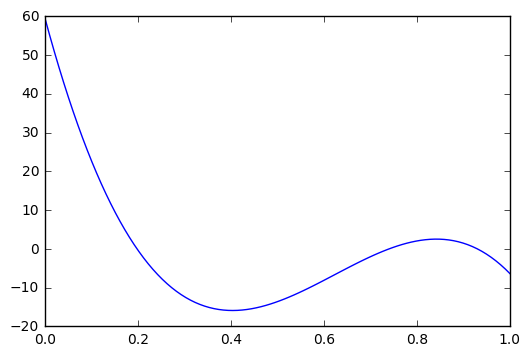

In [35]:
cov_svd = np.linalg.svd(smooth_est)
est_eigv = cov_svd[1][:r]/N
est_eigf = cov_svd[0][:,:r]
mu_coef = (estmu2-estmu1) @ est_eigf
psi = (mu_coef/est_eigv) @ est_eigf.T
plt.plot(t,psi)

### Defining the classifier $T(X)$ as above with the difference that the scalar products are taken on the support of the fragments.  

In [36]:
def test_frag(Y, start, end):
    ans = (Y[start:end] @ psi[start:end] - estmu1[start:end] @ psi[start:end])**2 - \
          (Y[start:end] @ psi[start:end] - estmu2[start:end] @ psi[start:end])**2
    return ans/((end-start)**2)

In [37]:
def new_test_frag(Y,cov,start,end):
    cov_svd = np.linalg.svd(cov[start:end,start:end])
    est_eigv = cov_svd[1][:r]/N
    est_eigf = cov_svd[0][:,:r]
    mu_coef = (estmu2[start:end]-estmu1[start:end]) @ est_eigf
    psi = (mu_coef/est_eigv) @ est_eigf.T
    ans = (Y[start:end] @ psi - estmu1[start:end] @ psi)**2 - \
          (Y[start:end] @ psi - estmu2[start:end] @ psi)**2
    return ans/((end-start)**2)

### Getting the classification result  for the training data. Here, the classification is far from perfect, with an error rate of 33%.

In [38]:
train_results = np.zeros((1,2))
for i in range(n):
    qw,er = new_test_frag(data1[i],smooth_est,bounds1[i][0],bounds1[i][1]), \
    new_test_frag(data2[i],smooth_est,bounds2[i][0],bounds2[i][1])
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

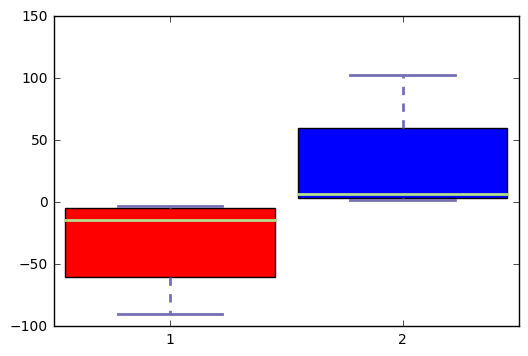

In [39]:
get_boxplots(train_results)

In [40]:
np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)

(0.0, 0.0)

### Generating a test dataset and perfoming classifcation on it. We get an error rate of 32%. 

In [41]:
test_results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
for _ in range(1000):
    tz = get_bounds(N,delta,1)[0].ravel()
    newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
    newX2 = generate_data(1,r,t,X,mu2,sds).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    test_results = np.r_[test_results,np.array([new_test_frag(newX1, smooth_est,tz[0],tz[1]), \
                                                new_test_frag(newX2,smooth_est,tz[0],tz[1])]).reshape((1,2))]
test_results = test_results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

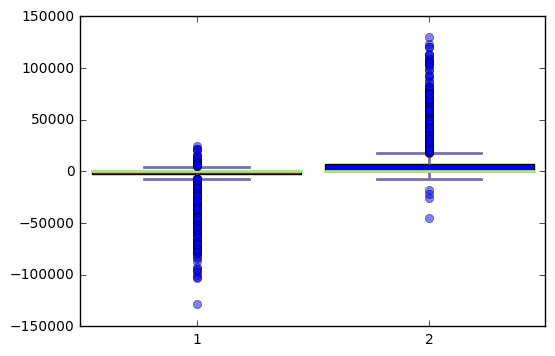

In [42]:
get_boxplots(test_results)

In [43]:
np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0)

(0.040000000000000001, 0.012999999999999999)

$ $

## Conclusion: Using classical LDA,  classification accuracy greatly decreases when the curves are not fully observed, even when the covariance kernel is well approximated. 

In [44]:
train_results = np.zeros((1,2))
cov = K
for i in range(n):
    qw,er = new_test_frag(data1[i],cov,bounds1[i][0],bounds1[i][1]), \
    new_test_frag(data2[i],cov,bounds2[i][0],bounds2[i][1])
    train_results = np.r_[train_results, np.array([qw,er]).reshape((1,2))]
train_results = train_results[1:]

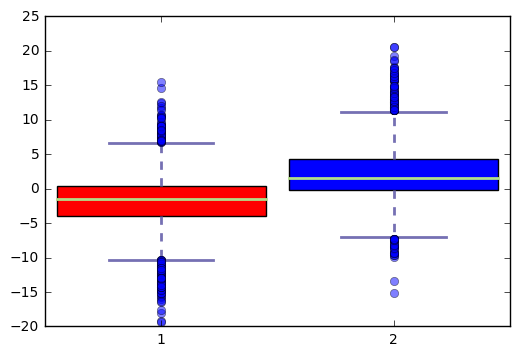

In [45]:
get_boxplots(train_results)

In [46]:
np.mean(train_results[:,0]>0),np.mean(train_results[:,1]<0)

(0.30133333333333334, 0.28466666666666668)

### Generating a test dataset and perfoming classifcation on it. We get an error rate of 32%. 

In [47]:
test_results = np.zeros((1,2))
newdata1 = np.zeros((1,N))
newdata2 = np.zeros((1,N))
cov = K
for _ in range(1000):
    tz = get_bounds(N,delta,1)[0].ravel()
    newX1 = generate_data(1,r,t,X,mu1,sds).ravel()
    newX2 = generate_data(1,r,t,X,mu2,sds).ravel()
    newdata1 = np.r_[newdata1, newX1.reshape((1,N))]
    newdata2 = np.r_[newdata2, newX2.reshape((1,N))]
    test_results = np.r_[test_results,np.array([new_test_frag(newX1, cov,tz[0],tz[1]), \
                                                new_test_frag(newX2,cov,tz[0],tz[1])]).reshape((1,2))]
test_results = test_results[1:]
newdata1 = newdata1[1:]
newdata2 = newdata2[1:]

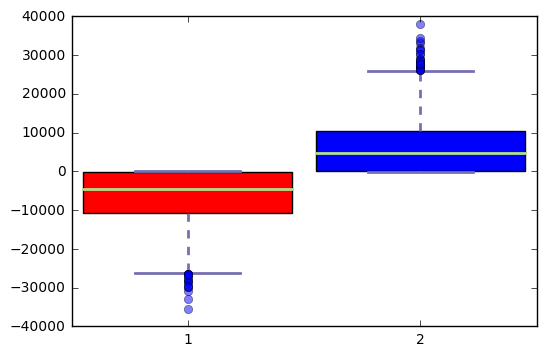

In [48]:
get_boxplots(test_results)

In [49]:
np.mean(test_results[:,0]>0),np.mean(test_results[:,1]<0)

(0.078, 0.060999999999999999)